# Estimating Agility of Learned Agents

This is most of the code used for the analysis in our 281b Final project, this code leverages some code we've written earlier, in particular 

contributions made in my forks of the following projects:
https://github.com/sgillen/bullet3
https://github.com/sgillen/baselines
https://github.com/sgillen/seagul.envs


Plus some utility functions I keep here:
https://github.com/sgillen/sgillen_research


Everything in this notebook, and some small changes to the above, were done for this class project, In addition to running many experiments with our baselines fork. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from seagul.rl.run_util.run import load_model #TODO this path is ugly
import numpy as np
from numpy import pi
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from seagul.nn import fit_model
import torch
from tqdm import trange
import tqdm

import torch.nn as nn
torch.set_default_dtype(torch.float32)

# Load data from runs done outside this notebook

#save_path = './data/car/bullet_car_v0_acktr_1e7'
#save_path = './data/car/signed_bullet_car'
#save_path = './data/car/new_baselines'
#save_path = './data/car/2_64_long'
save_path = './data/ppo_bench/ppo_test'
#save_path = './data/ppo_bench/bullet_test'

t_data = pd.read_csv(save_path + '/progress.csv' ) # this is data about the training
model, env = load_model(save_path) # This is loading the trained model for analysis

/Users/sgillen/anaconda3/envs/baselines/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2019-09-02-15-53-55-629005
Logging to /var/folders/qq/gpxz4l6s1tndfdhysbz8bdym0000gn/T/openai-2019-09-02-15-53-56-041078
env_type: mujoco
Training ppo2 on mujoco:InvertedPendulum-v2 with arguments 
{'nsteps': 2048, 'nminibatches': 32, 'lam': 0.95, 'gamma': 0.99, 'noptepochs': 10, 'log_interval': 1, 'ent_coef': 0.0, 'lr': <function mujoco.<locals>.<lambda> at 0x1400e5d08>, 'cliprange': 0.2, 'value_network': 'copy', 'num_layers': 3, 'num_hidden': 24, 'load_path': '/Users/sgillen/work/seagul/seagul/notebooks/est_agility/data/ppo_bench/ppo_test/saved_model', 'network': 'mlp'}
Running trained model


sum of rewards =  33.25892942165592
[33.25892942]


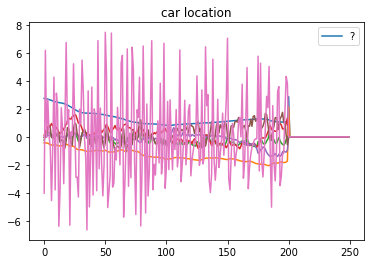

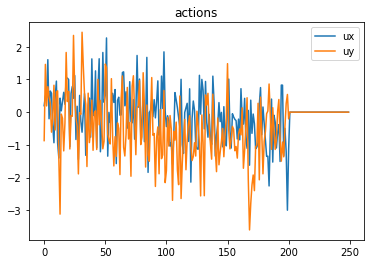

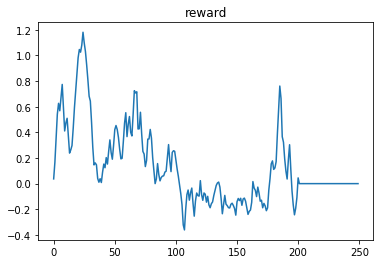

In [8]:
# This cell is optional

#   return [ distCurrPos2Goal, ang2Goal, thf, dxb, dyb, dthb, dthf ]


# Run single episode (will also render if you have that set)
myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps=250 

# Intialize action, state, and reward histories
action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))

# Run a single episode, this will render if you have that set in the environement or baselines
obs = env.reset()
for i in range(myenv.num_steps):
        actions, _, _, _ = model.step(obs)
        obs, reward, done, _ = env.step(actions)        
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        env.render()
        if done:
            break
            
            
# Plot results 
goal = myenv.goal

print('sum of rewards = ' , np.sum(reward_hist))

plt.plot(state_hist)
plt.title('states')
plt.legend (('?'))

plt.title('car location')

plt.figure()
plt.plot(action_hist)
plt.title('actions')
plt.legend (('ux', 'uy', 'uz'))

plt.plot

plt.figure()
plt.plot(reward_hist)
plt.title('reward')

print(sum(reward_hist))

In [ ]:
# Generate data for the supervised learning task

myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps=50

num_episodes = 20000
t_min = 25; t_max=myenv.num_steps; num_t = 10;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

ep_stride = 10

init_states = torch.zeros(t_vals.size, num_episodes, myenv.observation_space.shape[0]+1)  
final_states = torch.zeros(t_vals.size, num_episodes)

dt = myenv._timeStep
total_time = dt * myenv.num_steps  

init_states = []
final_states = []

ep = 0
for ep in trange(num_episodes):
        
        # init histories for this episode
        ep_action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        ep_state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        ep_reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()

        
        # set the goal for this iteratiom
        r_goal = np.random.uniform(low = .1, high = 5)
        th_goal = np.random.uniform(low=-pi, high = pi)
    
        x_goal = r_goal*np.cos(th_goal)
        y_goal = r_goal*np.sin(th_goal)
        
        myenv.goal = [x_goal,y_goal,.1]
     
              
        # run a single episode, we need to do it multiple times because noise... 

        obs, _,_,_ = myenv.step(np.zeros(myenv.action_space.shape))
        #init_states.append(torch.cat((torch.tensor(obs.squeeze()[0:2],dtype=torch.float32), torch.tensor(t_rem,dtype=torch.float32).reshape(1))))
        init_states.append(torch.tensor(obs.squeeze(),dtype=torch.float32))

        for i in range(myenv.num_steps):
            actions, value, _, log_prob = model.step(obs)
            obs, reward, done, _ = env.step(actions)  


            ep_action_hist[i,:] = np.copy(actions)
            ep_state_hist[i,:] = np.copy(obs)
            ep_reward_hist[i,:] = np.copy(reward)
            #env.render()
            if done:
                break

        # find the last state for all t(states go to zero at episode termination)
        #for i, state in enumerate(ep_state_hist[::ep_stride]):
        #    for it, _ in enumerate(ep_state_hist[i::ep_stride]):

          #      t_rem = it*dt
        t_rem = 75*dt
                #init_states.append(torch.cat((torch.tensor(state.squeeze()[0:2],dtype=torch.float32), torch.tensor(t_rem,dtype=torch.float32).reshape(1))))


        if any(ep_state_hist[-1,:]):
            final_states.append(0)          
        else:
            final_states.append(1)


                #goal_ach[ri,thi,it] = 1  
                

# # show the training data
# for i, state in enumerate(init_states):
#     if final_states[i]:
#         plt.polar(state[1], state[0], 'o', color = 'green')

# plt.figure()

# for i, state in enumerate(init_states):
#     if not final_states[i]:
#         plt.polar(state[1], state[0], 'o', color = 'red')

                

 74%|███████▍  | 14803/20000 [1:07:21<24:07,  3.59it/s]

  0%|          | 0/15 [00:00<?, ?it/s]/home/sgillen/miniconda3/envs/baselines/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
100%|██████████| 15/15 [00:06<00:00,  2.31it/s]

CPU times: user 1min 25s, sys: 187 ms, total: 1min 25s
Wall time: 6.13 s


<Figure size 432x288 with 0 Axes>

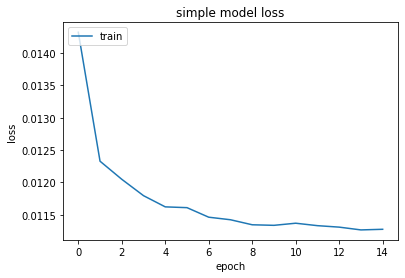

<Figure size 432x288 with 0 Axes>

In [4]:
# Do the supervised learning with MLP

# Define and train the feedforward network
es_model = nn.Sequential(
    nn.Linear(2,12),
    nn.ReLU(),
    nn.Linear(12,12),
    nn.ReLU(),
    nn.Linear(12,1),
    nn.Sigmoid()
)

# reshape variables for the training 
#state_train = torch.cat(init_states).reshape(-1,myenv.observation_space.shape[0] + 1)
state_train = torch.cat(init_states).reshape(-1,2)

state_min = torch.min(state_train, dim=0)[0]
state_max = torch.max(state_train, dim=0)[0]

# normalize the state training inpit
#state_train_normal = ((state_train - state_min)/state_max)
state_train_normal = state_train



final_state_train = torch.tensor(final_states, dtype=torch.float32)

#final_state_train = final_states.reshape(-1,myenv.observation_space.shape[0])
#final_state_train = final_states.reshape(-1,1)

%time loss_hist = fit_model(es_model, state_train_normal, final_state_train, num_epochs=15, learning_rate=1e-2, loss_fn=torch.nn.BCELoss(), shuffle=True)

plt.plot(loss_hist)
plt.title('simple model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure()

In [11]:
# do the supervised learning with various classifiers from ski kit learn

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.gaussian_process import GaussianProcessClassifier



SKI_X = [list(state.numpy()) for state in init_states ]
SKI_Y = final_states

svm = svm.SVC(class_weight={0:1, 1:.5}, probability=True,kernel='linear')
rfr = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
knn = neighbors.KNeighborsClassifier(15, weights='uniform')
gpc = GaussianProcessClassifier()

#SKI_X = X_train
#SKI_Y = Y_train

%time svm.fit(SKI_X, SKI_Y) 
%time print(svm.score(SKI_X, SKI_Y),)

%time rfr.fit(SKI_X, SKI_Y)
%time print(rfr.score(SKI_X, SKI_Y),)

%time knn.fit(SKI_X, SKI_Y)
%time print(knn.score(SKI_X, SKI_Y),)

#%time gpc.fit(SKI_X, SKI_Y)
#%time print(gpc.score(SKI_X, SKI_Y),)

CPU times: user 22.9 s, sys: 0 ns, total: 22.9 s
Wall time: 22.9 s
0.7314
CPU times: user 1.47 s, sys: 0 ns, total: 1.47 s
Wall time: 1.47 s
CPU times: user 489 ms, sys: 0 ns, total: 489 ms
Wall time: 488 ms
0.76445
CPU times: user 73.1 ms, sys: 0 ns, total: 73.1 ms
Wall time: 73.1 ms
CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 14.7 ms
0.86255
CPU times: user 68 ms, sys: 0 ns, total: 68 ms
Wall time: 68 ms


In [12]:
# Analyze the agility of our policy network with a grid search
# Also makes predictions for agility based on the predictor above

r_min = .1; r_max = 7; num_r = 10
r_vals = np.linspace(r_min, r_max, num_r)

th_min = -pi; th_max = pi; num_th = 30
th_vals = np.linspace(th_min, th_max, num_th)

t_min = 50; t_max=50; num_t = 1;
t_vals = np.linspace(t_min, t_max, num_t, dtype=np.int)

goal_ach = np.zeros((r_vals.size, th_vals.size, t_vals.size))
pred_ach = np.zeros((r_vals.size, th_vals.size, t_vals.size))

svm_pred_ach =  np.zeros((r_vals.size, th_vals.size, t_vals.size))
svm_pred_dec =  np.zeros((r_vals.size, th_vals.size, t_vals.size))

rfr_pred_ach =  np.zeros((r_vals.size, th_vals.size, t_vals.size))
knn_pred_ach =  np.zeros((r_vals.size, th_vals.size, t_vals.size))
gpc_pred_ach =  np.zeros((r_vals.size, th_vals.size, t_vals.size))



X_train_test = []
values = np.zeros((r_vals.size, th_vals.size))
log_prob_tot = np.zeros((r_vals.size, th_vals.size))

myenv = env.envs[0].env.env # OpenAI uses a bunch of wrappers around my env that don't maintain the member variables I put it
myenv.num_steps = 250


for ri,r in enumerate(tqdm.tqdm(r_vals)):
    for thi,th in enumerate(th_vals):
        
        action_hist = np.zeros((myenv.num_steps, myenv.action_space.shape[0]))
        state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
        reward_hist = np.zeros((myenv.num_steps, 1))

        obs = env.reset()
          
        x_goal = r*np.cos(th)
        y_goal = r*np.sin(th)
            
        myenv.goal = [x_goal,y_goal,.1]
        #myenv.goal = [1.8209177347168357, -1.6828028606611047, 0.1]
        #myenv.goal  = [1.8373192126473523, -0.9243333822434766, 0.1]

        obs,_,_,_ = myenv.step(np.zeros(myenv.action_space.shape))

        for it, t in enumerate(t_vals):
            net_input = torch.tensor(obs.squeeze()[0:2], dtype=torch.float32)
            clf_input = obs.squeeze()[0:2].reshape(1,-1)
            X_train_test.append(clf_input)

            #net_input = torch.cat((torch.tensor(obs.squeeze()[0:2]), torch.tensor(t*dt,dtype=torch.float32).view(1)))
            #net_input = (net_input - state_min)/state_max
            if es_model(net_input) > .5:
                pred_ach[ri,thi,it] = 1
            
            svm_pred_ach[ri,thi,it] = svm.predict(clf_input)
            svm_pred_dec[ri,thi,it] = svm.decision_function(clf_input)

            rfr_pred_ach[ri,thi,it] = rfr.predict(clf_input)
            knn_pred_ach[ri,thi,it] = knn.predict(clf_input)
            
            gpc_pred_ach[ri,thi,it] = rfr.predict(clf_input)




        actions, values[ri,thi], _, _, = model.step(obs)
        
        num_trials = 1
        for trial in range(num_trials):
            for i in range(myenv.num_steps):
                    actions, value, _, log_prob = model.step(obs)
                    obs, reward, done, _ = env.step(actions)        
                    action_hist[i,:] = np.copy(actions)
                    state_hist[i,:] = np.copy(obs)
                    reward_hist[i,:] = np.copy(reward)

                    log_prob_tot[ri,thi] -= log_prob
                    #env.render()
                    if done:
                        break


            for it, t in enumerate(t_vals):
                if state_hist[t-1,0] == 0:
                    goal_ach[ri,thi,it] += 1  
                
                    
                    
       # eps_end = np.max(np.nonzero(state_hist[:,1]))  

100%|██████████| 10/10 [01:44<00:00, 11.51s/it]


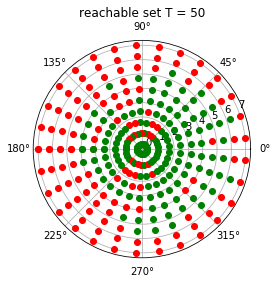

<Figure size 432x288 with 0 Axes>

In [13]:
# Print real agility map
X_train = []
Y_train = []
for it, t in enumerate(t_vals):
    for i,ival in enumerate(goal_ach[:,:,it]):
        for j,val in enumerate(ival):

            X_train.append([r_vals[i], th_vals[j]])
            Y_train.append(val)
            
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')

    title = 'reachable set T = '  +  str(t)
    plt.title(title ,y=1.08)
    plt.figure()

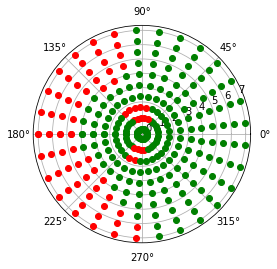

In [14]:
# Print neural net predicted agility map
for it, t in enumerate(t_vals):
    for i,ival in enumerate(pred_ach[:,:,it]):
        for j,val in enumerate(ival):
    
            
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')
          

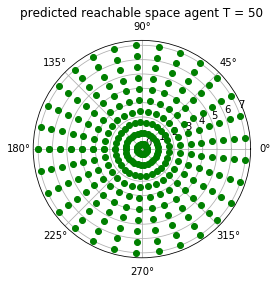

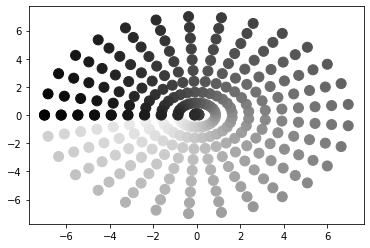

In [15]:
# Print svm predicted agility map
y_iter = iter(Y_train)
right = 0
for it, t in enumerate(t_vals):
    for i,ival in enumerate(svm_pred_ach[:,:,it]):
        for j,val in enumerate(ival):
            
            if val == next(y_iter):
                right+=1
            
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')
                

                
title = 'predicted reachable space agent T = '  +  str(t)
plt.title(title ,y=1.08)
plt.figure()


# Print actual prediction function for svm
x_vals = []
y_vals = []
colors = []

probs = np.exp(log_prob_tot)

for i,ival in enumerate(svm_pred_dec[:,:]):
    for j,val in enumerate(ival):
        x_vals.append(np.cos(th_vals[j])*r_vals[i])
        y_vals.append(np.sin(th_vals[j])*r_vals[i])
        colors.append((val - np.min(svm_pred_dec))/np.max(svm_pred_dec))

plt.scatter(np.reshape(x_vals,-1),np.reshape(y_vals,-1), c=np.reshape(colors,-1), s=100, cmap='gray_r')

<Figure size 432x288 with 0 Axes>

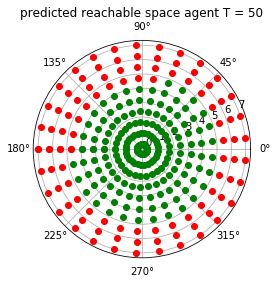

<Figure size 432x288 with 0 Axes>

In [10]:
# Print predicted agility map random forest
for it, t in enumerate(t_vals):
    for i,ival in enumerate(rfr_pred_ach[:,:,it]):
        for j,val in enumerate(ival):
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')
                

                
title = 'predicted reachable space agent T = '  +  str(t)
plt.title(title ,y=1.08)
plt.figure()

<Figure size 432x288 with 0 Axes>

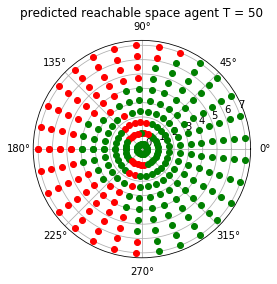

<Figure size 432x288 with 0 Axes>

In [16]:
# Print predicted agility map knn
for it, t in enumerate(t_vals):
    for i,ival in enumerate(knn_pred_ach[:,:,it]):
        for j,val in enumerate(ival):
            if val:
                plt.polar(th_vals[j],r_vals[i], 'o', color = 'green')
            else:
                plt.polar(th_vals[j], r_vals[i], 'o', color='red')
                

                
title = 'predicted reachable space agent T = '  +  str(t)
plt.title(title ,y=1.08)
plt.figure()

In [ ]:
# Print value fcn
x_vals = []
y_vals = []
colors = []

for i,ival in enumerate(values[:,:]):
    for j,val in enumerate(ival):
        x_vals.append(np.cos(th_vals[j])*r_vals[i])
        y_vals.append(np.sin(th_vals[j])*r_vals[i])
        colors.append((val)/np.max(values))
        

plt.scatter(np.reshape(x_vals,-1), np.reshape(y_vals,-1), c=np.reshape(colors,-1), s=100, cmap='gray_r')

In [ ]:
# Print the log probs
x_vals = []
y_vals = []
colors = []

probs = np.exp(log_prob_tot)

for i,ival in enumerate(1/log_prob_tot[:,:]):
    for j,val in enumerate(ival):
        x_vals.append(np.cos(th_vals[j])*r_vals[i])
        y_vals.append(np.sin(th_vals[j])*r_vals[i])
        colors.append((val - np.min(log_prob_tot))/np.max(log_prob_tot))

plt.scatter(np.reshape(x_vals,-1),np.reshape(y_vals,-1), c=np.reshape(colors,-1), s=100, cmap='gray_r')

In [ ]:
count= 0
m_total = 0
f_total = 0

m_list = []
f_list = []

for i, state in enumerate(state_train):
    count +=1 
    if(final_state_train[i] == 0):
        f_total += state_train[i,-1].item()
        f_list.append(state_train[i,-1].item())
    else:
        m_total += state_train[i,-1].item()
        m_list.append(state_train[i,-1].item())
        
plt.hist(m_list, bins='auto')
plt.figure()
plt.hist(f_list, bins='auto')

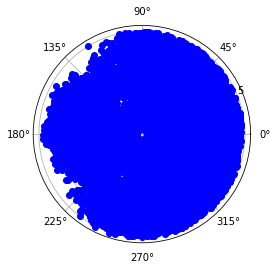

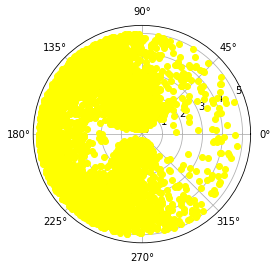

In [5]:
for i, state in enumerate(init_states):
    if final_states[i]:
        plt.polar(state[1], state[0], 'o', color = 'blue')

plt.figure()

for i, state in enumerate(init_states):
    if not final_states[i]:
        plt.polar(state[1], state[0], 'o', color = 'yellow')


In [ ]:
plt.plot(t_data['eprewmean'])
plt.title('reward vs epoch acktr agent')
plt.ylabel('reward mean')
plt.xlabel('epoch')

In [21]:
import pickle
with open("init_states_20000_6", "wb") as init_state_file:
    pickle.dump(init_states,init_state_file)
    
with open("final_states_20000_6", "wb") as final_state_file:
    pickle.dump(final_states,final_state_file)

In [1]:
import pickle

init_states = pickle.load(open("init_states_20000", "rb" ))
final_states = pickle.load(open("final_states_20000", "rb"))